# Mechanistic Interpretability: Neuron Interactions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def get_layer_activations(self, x, layer_name):
        x = x.view(-1, 784)
        activations = {}

        x = F.relu(self.fc1(x))
        if layer_name == 'fc1':
            activations['fc1'] = x.clone()

        x = F.relu(self.fc2(x))
        if layer_name == 'fc2':
            activations['fc2'] = x.clone()

        x = F.relu(self.fc3(x))
        if layer_name == 'fc3':
            activations['fc3'] = x.clone()

        x = self.fc4(x)
        if layer_name == 'fc4':
            activations['fc4'] = x.clone()

        return activations.get(layer_name, None)
    
    def get_all_activations(self, x):
        """Get activations from all layers"""
        x = x.view(-1, 784)
        activations = {}
        
        x = F.relu(self.fc1(x))
        activations['fc1'] = x.clone()
        
        x = F.relu(self.fc2(x))
        activations['fc2'] = x.clone()
        
        x = F.relu(self.fc3(x))
        activations['fc3'] = x.clone()
        
        x = self.fc4(x)
        activations['fc4'] = x.clone()
        
        return activations

In [3]:
# Load MNIST data
transform = transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [4]:
def train_model(model, train_loader, epochs=5):
    """Train the MNIST model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {total_loss/len(train_loader):.4f}')
    
    print("Training completed!")

## Neuron Correlation Analysis

Analyze how neurons co-activate to understand their functional relationships.

In [5]:
def analyze_neuron_correlations(model, data_loader, layer_name='fc2', max_samples=1000):
    """Analyze how neurons co-activate to understand their interactions"""
    model.eval()
    all_activations = []
    
    sample_count = 0
    with torch.no_grad():
        for data, target in data_loader:
            if sample_count >= max_samples:
                break
            
            activations = model.get_layer_activations(data, layer_name)
            all_activations.append(activations)
            sample_count += data.size(0)
    
    # Concatenate all activations
    all_activations = torch.cat(all_activations, dim=0)
    
    # Compute correlation matrix
    correlation_matrix = torch.corrcoef(all_activations.T).cpu().numpy()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap='RdBu_r', center=0, 
                vmin=-1, vmax=1, square=True)
    plt.title(f'Neuron-Neuron Correlations ({layer_name})')
    plt.xlabel('Neuron Index')
    plt.ylabel('Neuron Index')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix, all_activations

def find_neuron_clusters(correlation_matrix, threshold=0.6):
    """Find groups of highly correlated neurons"""
    high_corr_pairs = []
    n_neurons = correlation_matrix.shape[0]
    
    for i in range(n_neurons):
        for j in range(i+1, n_neurons):
            if abs(correlation_matrix[i, j]) > threshold:
                high_corr_pairs.append((i, j, correlation_matrix[i, j]))
    
    print(f"Found {len(high_corr_pairs)} neuron pairs with |correlation| > {threshold}")
    
    # Show top 10 most correlated pairs
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    print("\nTop 10 most correlated neuron pairs:")
    for i, (n1, n2, corr) in enumerate(high_corr_pairs[:10]):
        print(f"{i+1}. Neurons {n1}-{n2}: correlation = {corr:.3f}")
    
    return high_corr_pairs

## Neuron Clustering and Functional Groups

Use clustering to identify functional groups of neurons.

In [6]:
def cluster_neurons_by_activity(activations, n_clusters=8):
    """Cluster neurons based on their activation patterns"""
    # Use neuron activations across all samples as features
    neuron_profiles = activations.T.cpu().numpy()  # Shape: (n_neurons, n_samples)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(neuron_profiles)
    
    return cluster_labels, kmeans

def visualize_neuron_clusters(activations, cluster_labels, n_clusters):
    """Visualize neuron clusters using PCA"""
    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    neuron_profiles_2d = pca.fit_transform(activations.T.cpu().numpy())
    
    # Plot clusters
    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        plt.scatter(neuron_profiles_2d[mask, 0], neuron_profiles_2d[mask, 1], 
                   c=[colors[cluster_id]], label=f'Cluster {cluster_id}', 
                   alpha=0.7, s=50)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Neuron Clusters (PCA Visualization)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return pca

def analyze_cluster_specialization(model, data_loader, cluster_labels, layer_name='fc2'):
    """Analyze what each cluster specializes in"""
    model.eval()
    n_clusters = len(np.unique(cluster_labels))
    
    # Collect activations for each digit and cluster
    cluster_digit_activations = {cluster_id: {digit: [] for digit in range(10)} 
                               for cluster_id in range(n_clusters)}
    
    with torch.no_grad():
        for data, target in data_loader:
            activations = model.get_layer_activations(data, layer_name)
            
            for digit in range(10):
                digit_mask = (target == digit)
                if digit_mask.sum() > 0:
                    digit_activations = activations[digit_mask]
                    
                    # Average activations for each cluster
                    for cluster_id in range(n_clusters):
                        cluster_mask = cluster_labels == cluster_id
                        cluster_neurons = digit_activations[:, cluster_mask]
                        if cluster_neurons.size(1) > 0:
                            avg_activation = cluster_neurons.mean().item()
                            cluster_digit_activations[cluster_id][digit].append(avg_activation)
    
    # Compute average activations
    cluster_specialization = np.zeros((n_clusters, 10))
    for cluster_id in range(n_clusters):
        for digit in range(10):
            if cluster_digit_activations[cluster_id][digit]:
                cluster_specialization[cluster_id, digit] = np.mean(
                    cluster_digit_activations[cluster_id][digit])
    
    # Visualize specialization
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_specialization, annot=True, fmt='.2f', 
                xticklabels=[f'Digit {i}' for i in range(10)],
                yticklabels=[f'Cluster {i}' for i in range(n_clusters)],
                cmap='viridis')
    plt.title('Cluster Specialization by Digit')
    plt.xlabel('Digit Class')
    plt.ylabel('Neuron Cluster')
    plt.tight_layout()
    plt.show()
    
    # Find most specialized clusters
    print("\nCluster specialization analysis:")
    for cluster_id in range(n_clusters):
        cluster_size = np.sum(cluster_labels == cluster_id)
        best_digit = np.argmax(cluster_specialization[cluster_id])
        specialization_score = cluster_specialization[cluster_id, best_digit]
        print(f"Cluster {cluster_id} ({cluster_size} neurons): Most active for digit {best_digit} (activation: {specialization_score:.3f})")
    
    return cluster_specialization

## Pairwise Neuron Interaction Analysis

Study how pairs of neurons interact and influence each other.

In [7]:
def analyze_neuron_interactions(model, data_loader, layer_name='fc2', target_digit=7):
    """Analyze how neurons interact for specific digit recognition"""
    model.eval()
    
    # Collect activations for target digit
    target_activations = []
    other_activations = []
    
    with torch.no_grad():
        for data, target in data_loader:
            activations = model.get_layer_activations(data, layer_name)
            
            target_mask = (target == target_digit)
            other_mask = (target != target_digit)
            
            if target_mask.sum() > 0:
                target_activations.append(activations[target_mask])
            if other_mask.sum() > 0:
                other_activations.append(activations[other_mask])
    
    target_activations = torch.cat(target_activations, dim=0)
    other_activations = torch.cat(other_activations, dim=0)
    
    # Compute correlations for target digit vs others
    target_corr = torch.corrcoef(target_activations.T).cpu().numpy()
    other_corr = torch.corrcoef(other_activations.T).cpu().numpy()
    
    # Find neurons with different correlation patterns
    correlation_diff = np.abs(target_corr - other_corr)
    
    # Visualize differences
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Target digit correlations
    sns.heatmap(target_corr, cmap='RdBu_r', center=0, 
                vmin=-1, vmax=1, ax=axes[0], cbar=True)
    axes[0].set_title(f'Neuron Correlations for Digit {target_digit}')
    
    # Other digits correlations
    sns.heatmap(other_corr, cmap='RdBu_r', center=0, 
                vmin=-1, vmax=1, ax=axes[1], cbar=True)
    axes[1].set_title('Neuron Correlations for Other Digits')
    
    # Correlation differences
    sns.heatmap(correlation_diff, cmap='viridis', 
                ax=axes[2], cbar=True)
    axes[2].set_title('Correlation Differences')
    
    plt.tight_layout()
    plt.show()
    
    # Find most different neuron pairs
    n_neurons = correlation_diff.shape[0]
    diff_pairs = []
    
    for i in range(n_neurons):
        for j in range(i+1, n_neurons):
            diff_pairs.append((i, j, correlation_diff[i, j]))
    
    diff_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\nTop 10 neuron pairs with most different correlations for digit {target_digit}:")
    for i, (n1, n2, diff) in enumerate(diff_pairs[:10]):
        target_corr_val = target_corr[n1, n2]
        other_corr_val = other_corr[n1, n2]
        print(f"{i+1}. Neurons {n1}-{n2}: Target corr = {target_corr_val:.3f}, Other corr = {other_corr_val:.3f}, Diff = {diff:.3f}")
    
    return target_corr, other_corr, correlation_diff

## Circuit Analysis: Information Flow Between Layers

Analyze how information flows through the network layers.

In [8]:
def analyze_information_flow(model, data_loader, max_samples=500):
    """Analyze how information flows between layers"""
    model.eval()
    
    layer_activations = {'fc1': [], 'fc2': [], 'fc3': [], 'fc4': []}
    targets = []
    
    sample_count = 0
    with torch.no_grad():
        for data, target in data_loader:
            if sample_count >= max_samples:
                break
            
            all_activations = model.get_all_activations(data)
            
            for layer_name, activations in all_activations.items():
                layer_activations[layer_name].append(activations)
            
            targets.append(target)
            sample_count += data.size(0)
    
    # Concatenate all activations
    for layer_name in layer_activations:
        layer_activations[layer_name] = torch.cat(layer_activations[layer_name], dim=0)
    
    targets = torch.cat(targets, dim=0)
    
    # Compute layer-to-layer correlations
    layer_names = ['fc1', 'fc2', 'fc3', 'fc4']
    n_layers = len(layer_names)
    
    # For each pair of consecutive layers, compute cross-correlations
    fig, axes = plt.subplots(1, n_layers-1, figsize=(15, 4))
    
    for i in range(n_layers-1):
        layer1_name = layer_names[i]
        layer2_name = layer_names[i+1]
        
        # Sample subset of neurons for computational efficiency
        layer1_acts = layer_activations[layer1_name][:, :50]  # First 50 neurons
        layer2_acts = layer_activations[layer2_name][:, :50]  # First 50 neurons
        
        # Compute cross-correlation matrix
        combined = torch.cat([layer1_acts, layer2_acts], dim=1)
        cross_corr = torch.corrcoef(combined.T).cpu().numpy()
        
        # Extract the cross-correlation part
        n1 = layer1_acts.size(1)
        n2 = layer2_acts.size(1)
        cross_corr_subset = cross_corr[:n1, n1:n1+n2]
        
        # Plot
        sns.heatmap(cross_corr_subset, cmap='RdBu_r', center=0,
                   ax=axes[i], cbar=True)
        axes[i].set_title(f'{layer1_name} → {layer2_name}')
        axes[i].set_xlabel(f'{layer2_name} neurons')
        axes[i].set_ylabel(f'{layer1_name} neurons')
    
    plt.tight_layout()
    plt.show()
    
    return layer_activations

def analyze_layer_representations(layer_activations, targets):
    """Analyze how digit representations evolve across layers"""
    layer_names = ['fc1', 'fc2', 'fc3', 'fc4']
    
    # Compute digit separability in each layer using PCA
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, layer_name in enumerate(layer_names):
        activations = layer_activations[layer_name].cpu().numpy()
        
        # Apply PCA
        pca = PCA(n_components=2)
        activations_2d = pca.fit_transform(activations)
        
        # Plot different digits
        colors = plt.cm.tab10(np.linspace(0, 1, 10))
        for digit in range(10):
            mask = targets.cpu().numpy() == digit
            if mask.sum() > 0:
                axes[i].scatter(activations_2d[mask, 0], activations_2d[mask, 1],
                              c=[colors[digit]], label=f'{digit}', alpha=0.6, s=20)
        
        axes[i].set_title(f'{layer_name} Representations\n'
                         f'PC1: {pca.explained_variance_ratio_[0]:.2%}, '
                         f'PC2: {pca.explained_variance_ratio_[1]:.2%}')
        axes[i].set_xlabel('PC1')
        axes[i].set_ylabel('PC2')
        if i == 0:
            axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

## Run Mechanistic Analysis

In [9]:
# Train the model
model = MNISTNet()
print("Training model...")
train_model(model, train_loader, epochs=5)

# Test model accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Training model...
Epoch 1/5, Average Loss: 0.3146
Epoch 1/5, Average Loss: 0.3146
Epoch 2/5, Average Loss: 0.1166
Epoch 2/5, Average Loss: 0.1166
Epoch 3/5, Average Loss: 0.0777
Epoch 3/5, Average Loss: 0.0777
Epoch 4/5, Average Loss: 0.0567
Epoch 4/5, Average Loss: 0.0567
Epoch 5/5, Average Loss: 0.0436
Training completed!
Test Accuracy: 97.86%
Epoch 5/5, Average Loss: 0.0436
Training completed!
Test Accuracy: 97.86%


Analyzing neuron correlations...


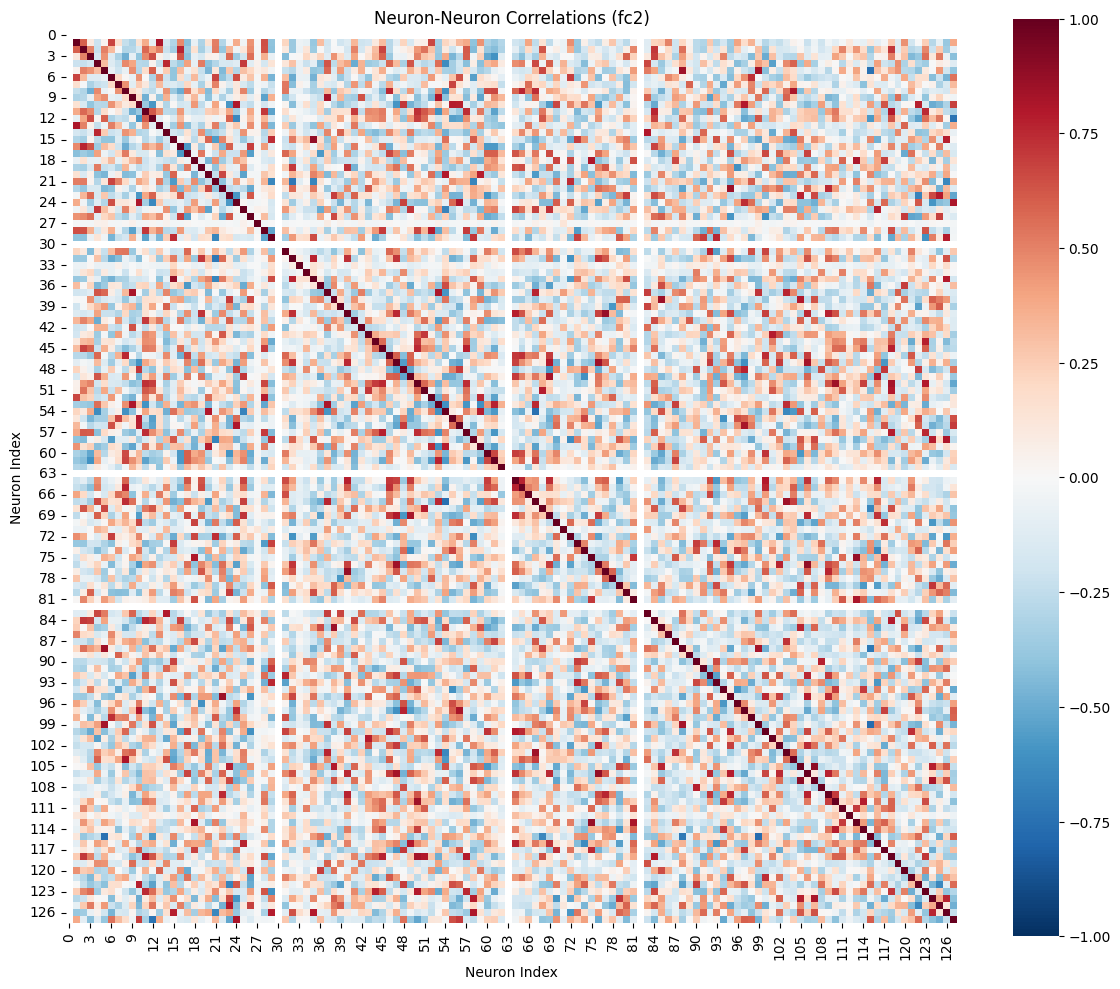

Found 756 neuron pairs with |correlation| > 0.5

Top 10 most correlated neuron pairs:
1. Neurons 105-107: correlation = 0.896
2. Neurons 76-106: correlation = 0.880
3. Neurons 15-35: correlation = 0.878
4. Neurons 75-113: correlation = 0.874
5. Neurons 40-77: correlation = 0.873
6. Neurons 38-85: correlation = 0.855
7. Neurons 22-95: correlation = 0.852
8. Neurons 50-110: correlation = 0.848
9. Neurons 47-76: correlation = 0.846
10. Neurons 67-103: correlation = 0.846


In [10]:
# Analyze neuron correlations
print("Analyzing neuron correlations...")
correlation_matrix, all_activations = analyze_neuron_correlations(model, test_loader, layer_name='fc2')
high_corr_pairs = find_neuron_clusters(correlation_matrix, threshold=0.5)

Clustering neurons by activity patterns...


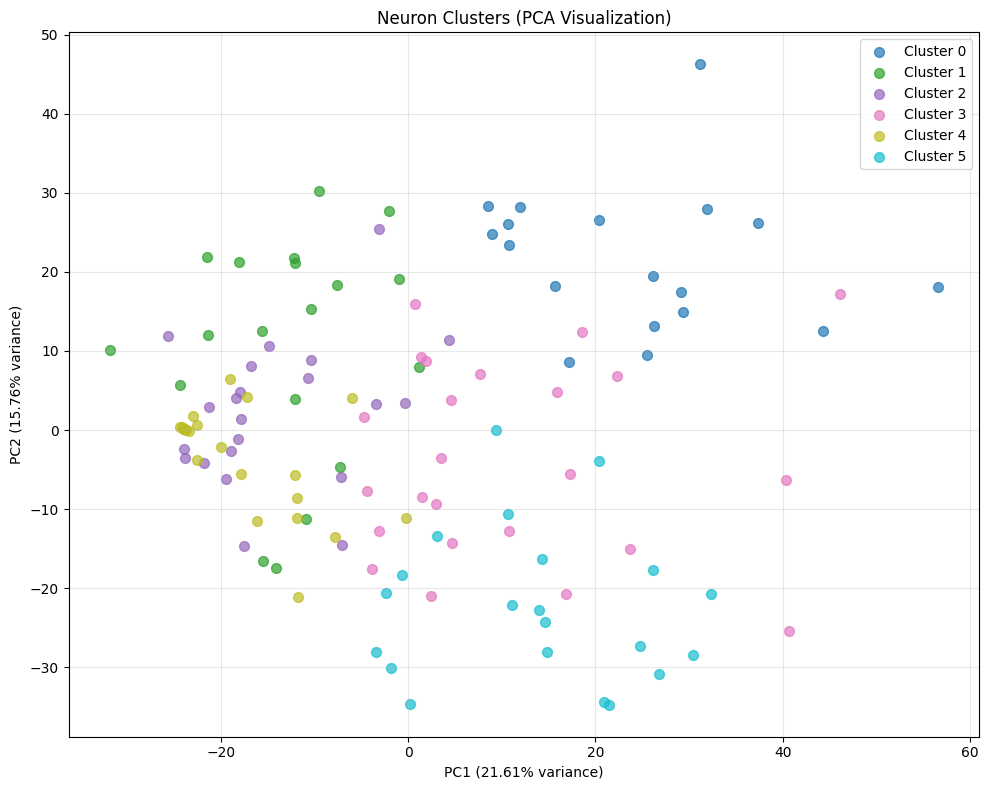

In [11]:
# Cluster neurons by activity patterns
print("Clustering neurons by activity patterns...")
cluster_labels, kmeans = cluster_neurons_by_activity(all_activations, n_clusters=6)
pca = visualize_neuron_clusters(all_activations, cluster_labels, n_clusters=6)

Analyzing cluster specialization...


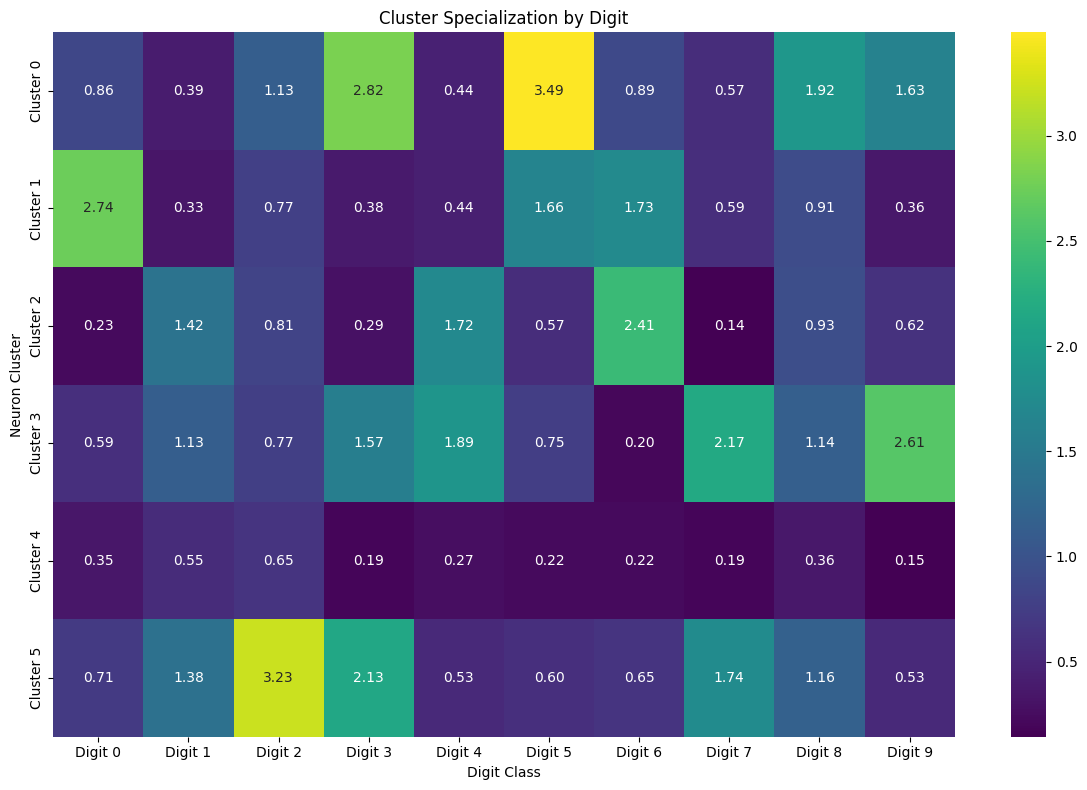


Cluster specialization analysis:
Cluster 0 (18 neurons): Most active for digit 5 (activation: 3.492)
Cluster 1 (19 neurons): Most active for digit 0 (activation: 2.741)
Cluster 2 (22 neurons): Most active for digit 6 (activation: 2.413)
Cluster 3 (24 neurons): Most active for digit 9 (activation: 2.609)
Cluster 4 (24 neurons): Most active for digit 2 (activation: 0.647)
Cluster 5 (21 neurons): Most active for digit 2 (activation: 3.229)


In [12]:
# Analyze cluster specialization
print("Analyzing cluster specialization...")
cluster_specialization = analyze_cluster_specialization(model, test_loader, cluster_labels, layer_name='fc2')

Analyzing neuron interactions for digit 7...


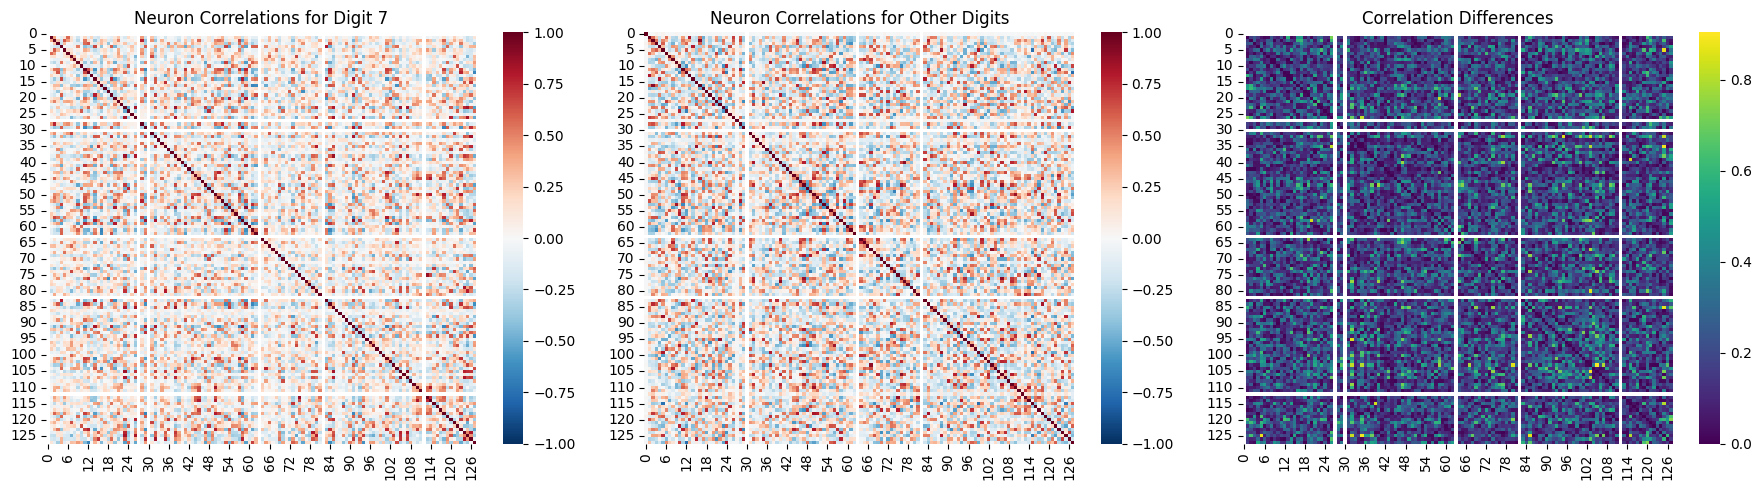


Top 10 neuron pairs with most different correlations for digit 7:
1. Neurons 0-1: Target corr = nan, Other corr = -0.007, Diff = nan
2. Neurons 0-2: Target corr = nan, Other corr = -0.002, Diff = nan
3. Neurons 0-3: Target corr = nan, Other corr = 0.031, Diff = nan
4. Neurons 0-4: Target corr = nan, Other corr = 0.004, Diff = nan
5. Neurons 0-5: Target corr = nan, Other corr = 0.032, Diff = nan
6. Neurons 0-6: Target corr = nan, Other corr = -0.004, Diff = nan
7. Neurons 0-7: Target corr = nan, Other corr = -0.015, Diff = nan
8. Neurons 0-8: Target corr = nan, Other corr = -0.009, Diff = nan
9. Neurons 0-9: Target corr = nan, Other corr = 0.025, Diff = nan
10. Neurons 0-10: Target corr = nan, Other corr = -0.014, Diff = nan


In [13]:
# Analyze neuron interactions for specific digit
print("Analyzing neuron interactions for digit 7...")
target_corr, other_corr, correlation_diff = analyze_neuron_interactions(model, test_loader, layer_name='fc2', target_digit=7)

Analyzing information flow between layers...


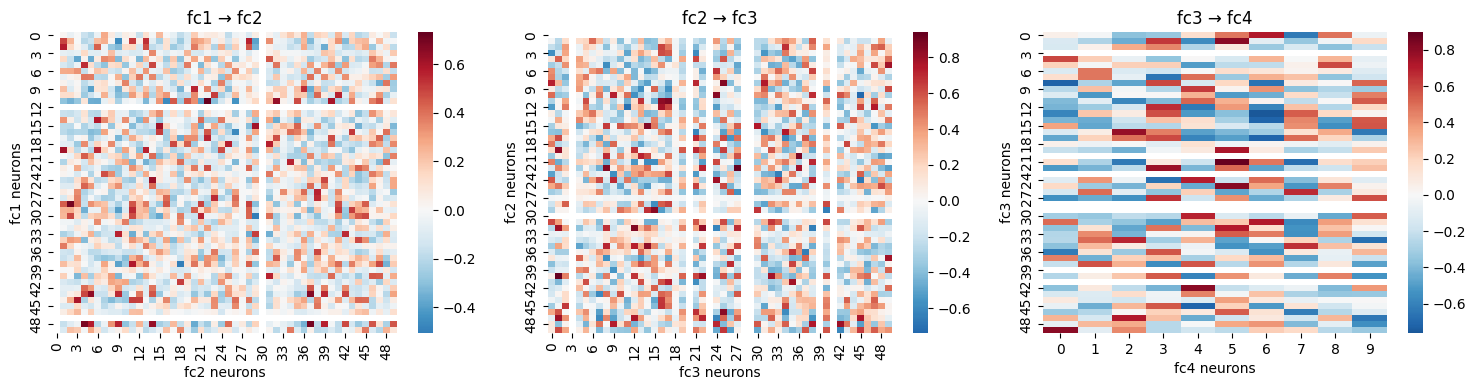

IndexError: boolean index did not match indexed array along axis 0; size of axis is 1024 but size of corresponding boolean axis is 1000

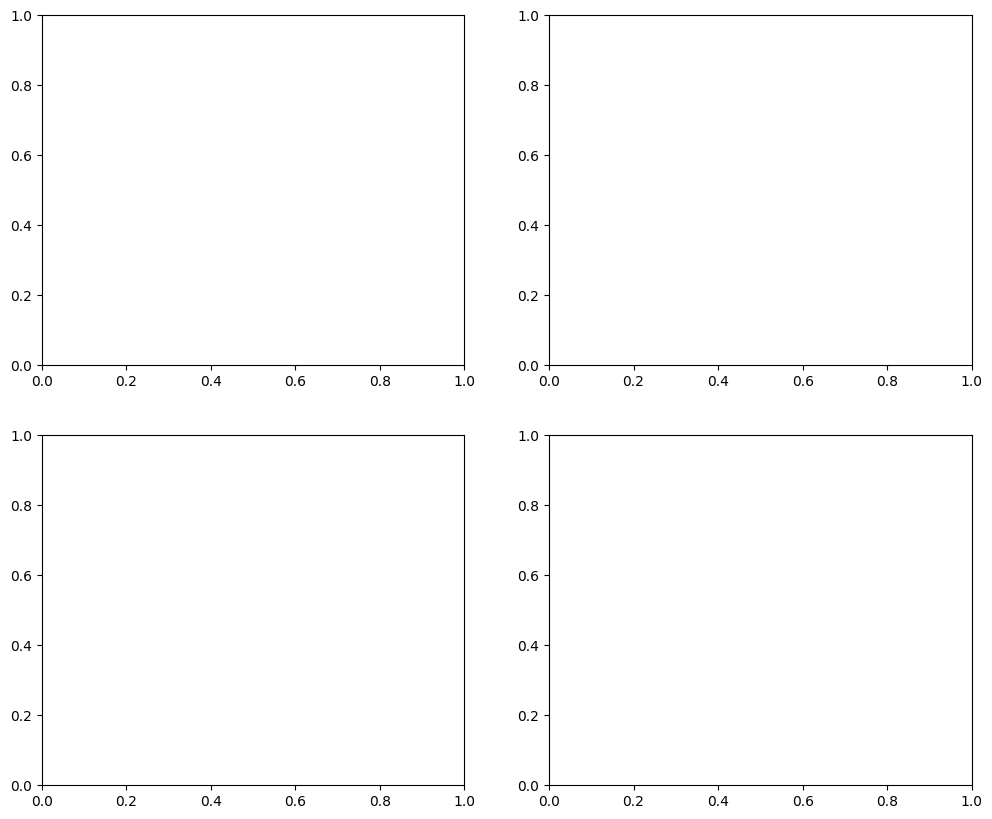

In [14]:
# Analyze information flow between layers
print("Analyzing information flow between layers...")
layer_activations = analyze_information_flow(model, test_loader, max_samples=1000)

# Get targets for representation analysis
targets = []
sample_count = 0
with torch.no_grad():
    for data, target in test_loader:
        if sample_count >= 1000:
            break
        targets.append(target)
        sample_count += data.size(0)
targets = torch.cat(targets, dim=0)[:1000]  # Limit to match layer_activations

analyze_layer_representations(layer_activations, targets)